In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import umap

In [38]:
pca_data = np.loadtxt("./spec/pca_data_online_1.txt")

In [39]:
pca_data.shape

(1000, 500)

In [40]:
def perform_pca(data):
    #subtract the mean to center the data and remove bias
    # x = x - mean(x) 
    mean_data = data - np.mean(data, axis=0)
    
    # cov = 1/(n-1) * x^T * x  , where x is the centered data 
    covariance_matrix = np.cov(mean_data, rowvar=False)
    
    # detailed calculation of eigenvectors and eigenvalues are in notes folder. 
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    # higher eigenvalues correspond to higher variance.
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    # Project data onto the top 2 eigenvectors
    top_2_eigenvectors = eigenvectors[:, :2]
    projected_data = np.dot(mean_data, top_2_eigenvectors)
    
    return projected_data, top_2_eigenvectors, eigenvalues

In [41]:
def plot_pca(data):

    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], alpha=0.6, s=10, color="blue")
    plt.title("2D Scatter Plot - PCA")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.show()

In [42]:
def plot_umap_tsne(data):

    # UMAP
    umap_proj = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=73).fit_transform(data)
    plt.figure(figsize=(8, 6))
    plt.scatter(umap_proj[:, 0], umap_proj[:, 1], alpha=0.6, s=50, color="green")
    plt.title("UMAP Projection")
    plt.grid(True)
    plt.show()

    # t-SNE
    tsne_proj = TSNE(n_components=2, perplexity=20, random_state=73).fit_transform(data)
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_proj[:, 0], tsne_proj[:, 1], alpha=0.6, s=10, color="red")
    plt.title("t-SNE Projection")
    plt.grid(True)
    plt.show()

In [43]:
from scipy.special import factorial  # Import for factorial computation

def em_algorithm(data, max_iter=250, tol=1e-6):
    # Initialize parameters
    np.random.seed(42)
    λ1, λ2 = np.random.rand(2) * 10  # avg number of children/event in family 1 and 2
    π1, π2 = 0.5, 0.5  # probability of family 1 and 2

    n_samples = len(data)
    responsibilities = np.zeros((n_samples, 2))

    for iteration in range(max_iter):
        # E-step: Compute responsibilities
        prob1 = π1 * (λ1**data * np.exp(-λ1)) / factorial(data, exact=False).clip(min=1) # lembda^x * e^(-lembda) / x! for all x in data
        prob2 = π2 * (λ2**data * np.exp(-λ2)) / factorial(data, exact=False).clip(min=1) 

        # prob1 means the probability of data point belonging to family 1 
        sum_probs = prob1 + prob2

        # responsibilities are the probability of data point belonging to family 1 or 2 ( n*2 matrix)
        responsibilities[:, 0] = prob1 / sum_probs
        responsibilities[:, 1] = prob2 / sum_probs

        # M-step: Update parameters
        π1_new = responsibilities[:, 0].mean() # mean of all the probabilities of data points belonging to family 1
        π2_new = responsibilities[:, 1].mean() # mean of all the probabilities of data points belonging to family 2


        # lembda = sum(x * p(x)) / sum(p(x))  
        # where x is the data point and p(x) is the probability of data point belonging to family 1 or 2
        # basically, lembda is the expected value of the data points belonging to family 1 or 2
        λ1_new = (responsibilities[:, 0] * data).sum() / responsibilities[:, 0].sum()
        λ2_new = (responsibilities[:, 1] * data).sum() / responsibilities[:, 1].sum()

        # Check for convergence
        if np.abs(λ1 - λ1_new) < tol and np.abs(λ2 - λ2_new) < tol:
            break

        # Update parameters for the next iteration
        π1, π2 = π1_new, π2_new
        λ1, λ2 = λ1_new, λ2_new

    return λ1, λ2, π1, π2


Running PCA...


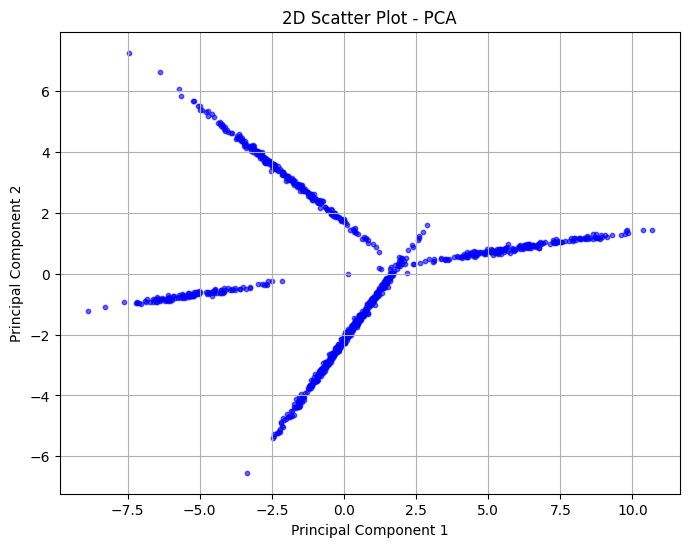

/home/are/miniconda3/envs/ml-lab/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


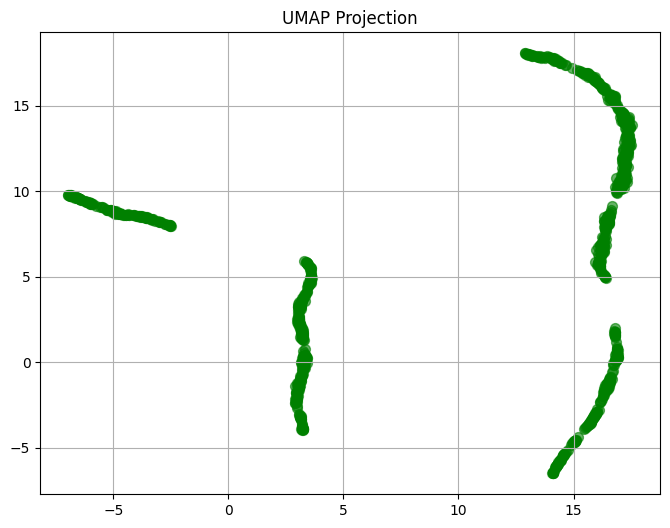

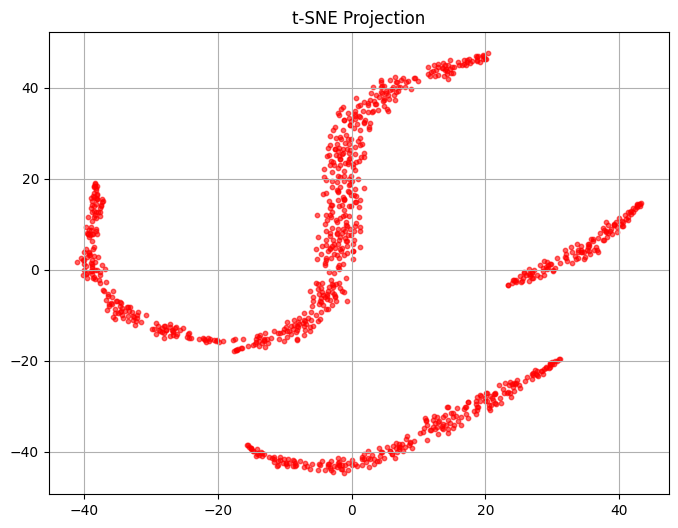

Running EM Algorithm...
Estimated parameters:
Mean (λ1) for families with family planning: 10.715391289157663
Mean (λ2) for families without family planning: 15.540104093864862
Proportion (π1) of families with family planning: 0.49124252360730913
Proportion (π2) of families without family planning: 0.5087574763926909


In [44]:
print("Running PCA...")
pca_result, _, _ = perform_pca(pca_data)
plot_pca(pca_result)
plot_umap_tsne(pca_data)

# EM Task
print("Running EM Algorithm...")
em_data = np.loadtxt("./spec/em_data_online_1.txt")
λ1, λ2, π1, π2 = em_algorithm(em_data)
print(f"Estimated parameters:")
print(f"Mean (λ1) for families with family planning: {λ1}")
print(f"Mean (λ2) for families without family planning: {λ2}")
print(f"Proportion (π1) of families with family planning: {π1}")
print(f"Proportion (π2) of families without family planning: {π2}")